In [1]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import joblib
import json
import tensorflow as tf



In [2]:
# Load the models and scalers
xgb_model = joblib.load('xgboost_model.joblib')
lstm_model = tf.keras.models.load_model('lstm_model.keras')
feature_scaler = joblib.load('feature_scaler.joblib')
target_scaler = joblib.load('target_scaler.joblib')

# Load sequence length from config
with open('config.json', 'r') as f:
    config = json.load(f)
    sequence_length = config['sequence_length']

In [3]:
data = pd.read_csv('../datasets/msft.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Volatility (Standard Deviation): Capture price fluctuations:
# for ma in ma_day:
#     column_name = f"Volatility_{ma}d"
#     data[column_name] = data['Close'].rolling(window=ma).std()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# # Trading Volume Moving Average: Add moving averages for the Volume
# for ma in ma_day:
#     data[f"Volume_MA_{ma}"] = data['Volume'].rolling(window=ma).mean()

data.dropna(inplace=True)
data.head(500)

         Date    Open   High    Low  Close    Volume
0  2014-01-02  37.350  37.40  37.10  37.16  30632200
1  2014-01-03  37.200  37.22  36.60  36.91  31134800
2  2014-01-06  36.850  36.89  36.11  36.13  43603700
3  2014-01-07  36.325  36.49  36.21  36.41  35802800
4  2014-01-08  36.000  36.14  35.58  35.76  59971700


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2014-03-14,37.651,38.135,37.5058,37.70,27195600,37.940,38.005,37.8600,37.0199,37.909261,37.921948,37.762257,37.373170,50.127877
50,2014-03-17,37.900,38.410,37.7900,38.05,20479600,37.986,38.032,37.8815,37.0377,37.956174,37.945230,37.789661,37.399713,56.204380
51,2014-03-18,38.260,39.900,38.2200,39.55,64063900,38.292,38.146,37.9880,37.0905,38.487449,38.237007,37.957312,37.484038,68.772563
52,2014-03-19,39.470,39.550,38.9100,39.27,35597200,38.492,38.262,38.0760,37.1533,38.748300,38.424824,38.082330,37.554076,62.983425
53,2014-03-20,39.250,40.649,39.2400,40.33,59269800,38.980,38.480,38.2050,37.2317,39.275533,38.771219,38.296394,37.662935,66.721854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2016-03-02,52.410,52.960,52.1550,52.95,29289884,51.962,51.901,51.2715,52.5779,52.161885,51.875563,51.776638,52.111062,66.430020
545,2016-03-03,52.970,52.970,51.7800,52.35,24427813,52.012,51.917,51.2810,52.5423,52.224590,51.961825,51.831244,52.120432,62.739464
546,2016-03-04,52.400,52.450,51.7100,52.03,33034150,52.158,51.938,51.2825,52.4863,52.159727,51.974220,51.850173,52.116886,57.688442
547,2016-03-07,51.560,51.800,50.5800,51.03,38428816,52.188,51.776,51.3260,52.3999,51.783151,51.802544,51.772062,52.074263,49.710425


In [4]:
# Prepare features and target
# feature_columns = ['EMA for 50 days', 'RSI_14']  # Features we want to use

from xgboost import XGBRegressor


feature_columns = [
    'Close',          # Most important feature (direct price information)
    'Low',            # Important price-related feature
    'High',           # Important price-related feature
    'Open',           # Important price-related feature
    'EMA for 5 days', # Short-term trend indicator
    'MA for 5 days',  # Short-term trend indicator
    'RSI_14'          # Momentum indicator
]

X = data[feature_columns].values
y = data['Close'].values

# Scale features using the loaded scaler
X_scaled = feature_scaler.transform(X)

# Get XGBoost predictions
xgb_predictions = xgb_model.predict(X_scaled)

# Combine features with XGBoost predictions
combined_features = np.column_stack((X_scaled, xgb_predictions))

# Create sequences for LSTM
X_sequences = []
y_actual = []

for i in range(len(combined_features) - sequence_length):
    X_sequences.append(combined_features[i:(i + sequence_length)])
    y_actual.append(y[i + sequence_length])

X_sequences = np.array(X_sequences)
y_actual = np.array(y_actual)

In [5]:
# Make predictions
lstm_predictions = lstm_model.predict(X_sequences)
final_predictions = target_scaler.inverse_transform(lstm_predictions)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error


# Get actual values
actual_values = y[sequence_length:]

# Calculate the split point for the last 20% of the data
split_idx = int(len(actual_values) * 0.8)

# Get only the validation portion (last 20%)
val_actual = actual_values[split_idx:]
val_predictions = final_predictions[split_idx:]

# Calculate metrics on validation set only
mse = mean_squared_error(val_actual, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actual, val_predictions)
r2 = r2_score(val_actual, val_predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE:{rmse:.2f} ")
print(f"MAE: {mae:.2f} ")
print(f"R2 Score: {r2:.4f} ")



Performance Metrics:
MSE: 679.42
RMSE:26.07 
MAE: 22.99 
R2 Score: 0.6749 


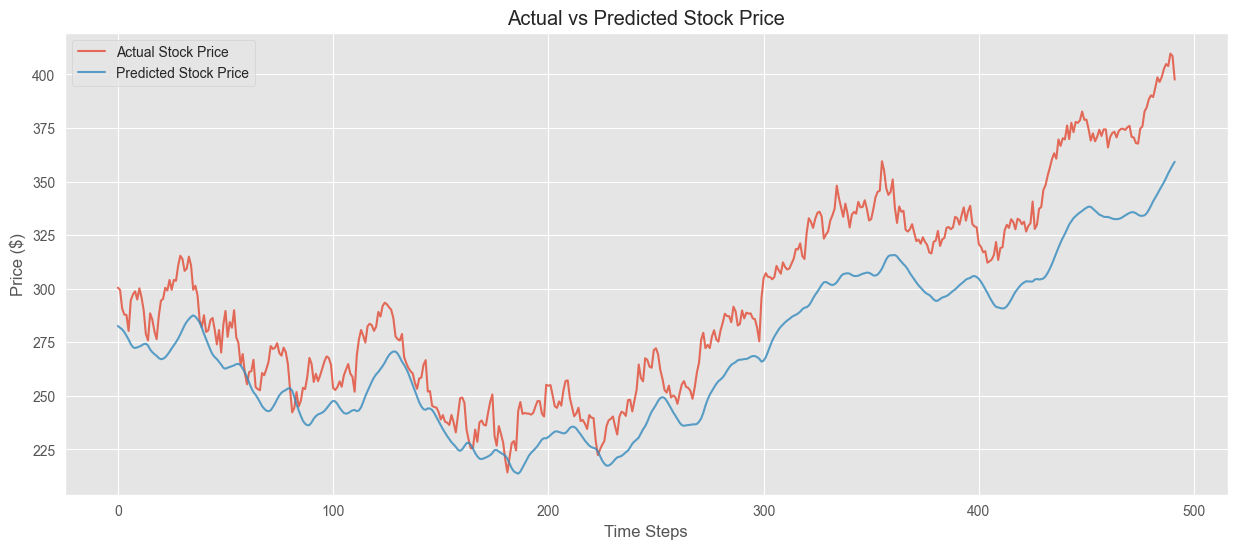

In [7]:
# Plot only the results
plt.figure(figsize=(15, 6))
plt.plot(val_actual, label='Actual Stock Price', alpha=0.8)
plt.plot(val_predictions, label='Predicted Stock Price', alpha=0.8)
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()